# Singular Triplet via Riemannian optimization


Exponential map on the n-sphere: $\gamma(t) = \cos(\|\vec{v}\|t) \vec{p} + \sin(\|\vec{v}\|t) \frac{\vec{v}}{\|\vec{v}\|}$  (see: https://math.stackexchange.com/a/1930880/99220)

Exponential map on the product manifold: $\exp_{U×V} = \expᵤ × \expᵥ$  (https://math.stackexchange.com/q/2354500/99220)


Therefore, on the (m,n)-torus $𝕋_{m,n} = 𝕊_m×𝕊_n$, we should have:


The exponential map at point $\vec{p}=(\vec{u}, \vec{v})$ in direction $\vec{g}=(\vec{g}ᵤ, \vec{g}ᵥ$

Is given by: 

$$γ(t) = \begin{pmatrix} 
    \cos(\|\vec{g}ᵤ\|t) \vec{u} + \sin(\|\vec{g}ᵤ\|t) \frac{\vec{g}ᵤ}{\|\vec{g}ᵤ\|} 
    \\ \cos(\|\vec{g}ᵥ\|t) \vec{v} + \sin(\|\vec{g}ᵥ\|t) \frac{\vec{g}ᵥ}{\|\vec{g}ᵥ\|}
\end{pmatrix}$$

## Application to maximal singular triplet

recall that we want to find the optimum of

$$\max_{\vec{u}, \vec{v}} \vec{u}ᵀ A \vec{v} \qquad{s.t.}\qquad  ‖u‖=1 ‖v‖=1$$

Which can be rephrased as

$$\max_{\vec{u}, \vec{v}} \vec{u}ᵀ A \vec{v} \qquad{s.t.}\qquad (u,v)∈𝕋_{m,n} $$

In [1]:
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

M, N = 8, 4
torch.manual_seed(0)
A = torch.randn(M, N) / torch.sqrt(torch.tensor(N))


def outer(t, x):
    """Outer product of a tensor and a vector."""
    return torch.einsum("..., d -> ...d", t, x)


def exp_map_torus(t, u, v, gu, gv):
    """Exponential map on the (m,n)-torus 𝕋_{m,n} = 𝕊_m×𝕊_n."""
    sigmaᵤ = gu.norm(dim=-1, keepdim=True)
    sigmaᵥ = gv.norm(dim=-1, keepdim=True)
    t = torch.as_tensor(t, dtype=torch.float32, device=u.device)

    return (
        outer(t, sigmaᵤ).cos() * u + outer(t, sigmaᵤ).sin() * gu / sigmaᵤ,
        outer(t, sigmaᵥ).cos() * v + outer(t, sigmaᵥ).sin() * gv / sigmaᵥ,
    )


def get_tangent(u, v):
    """compute the gradient at (u,v) and return the tangent vector."""
    gᵤ = A @ v
    gᵥ = A.T @ u

    # orthogonalize
    gᵤ -= u.dot(gᵤ) * u
    gᵥ -= v.dot(gᵥ) * v

    assert torch.allclose(
        u.dot(gᵤ), torch.zeros_like(u), atol=1e-6
    ), f"u is not orthogonal to gᵤ {u.dot(gᵤ)}"
    assert torch.allclose(
        v.dot(gᵥ), torch.zeros_like(v), atol=1e-6
    ), f"v is not orthogonal to gᵥ {v.dot(gᵥ)}"

    return gᵤ, gᵥ


def get_exponential_map(u, v):
    """Exponential map on the (m,n)-torus 𝕋_{m,n} = 𝕊_m×𝕊_n."""
    gᵤ, gᵥ = get_tangent(u, v)
    print(f"Wavelength ωᵤ: {2*torch.pi / gᵤ.norm():.4f}")
    print(f"Wavelength ωᵥ: {2*torch.pi / gᵥ.norm():.4f}")
    return lambda t: exp_map_torus(t, u, v, gᵤ, gᵥ)


def get_wavelength(u, v):
    gᵤ, gᵥ = get_tangent(u, v)
    return 2 * torch.pi / gᵤ.norm(), 2 * torch.pi / gᵥ.norm()


def get_sol(u, v):
    """Get optimal t value for both u and v (independently)."""
    # $λ=‖gᵤ‖$, $a≔uᵀ A v=σᵤ$ and $b≔\frac{gᵤᵀ A v}{λ}$
    gᵤ, gᵥ = get_tangent(u, v)
    λᵤ = gᵤ.norm()
    aᵤ = u.dot(A.mv(v))
    bᵤ = gᵤ.dot(A.mv(v)) / λᵤ
    τᵤ = torch.atan2(bᵤ, aᵤ) / λᵤ
    λᵥ = gᵥ.norm()
    aᵥ = v.dot(A.t().mv(u))
    bᵥ = gᵥ.dot(A.t().mv(u)) / λᵥ
    τᵥ = torch.atan2(bᵥ, aᵥ) / λᵥ
    print(f"Phase      τᵤ: {τᵤ:.4f}")
    print(f"Phase      τᵥ: {τᵥ:.4f}")
    return τᵤ, τᵥ


def value(u, v):
    return torch.einsum("...m, mn, ...n -> ...", u, A, v)

In [3]:
# initial guess
u = torch.randn(M)
v = torch.randn(N)
u /= u.norm()
v /= v.norm()

tensor([ 0.0968,  0.6379, -0.6513, -0.3993])

Wavelength ωᵤ: 3.8813
Wavelength ωᵥ: 8.0626
Phase      τᵤ: 1.0248
Phase      τᵥ: 2.2489


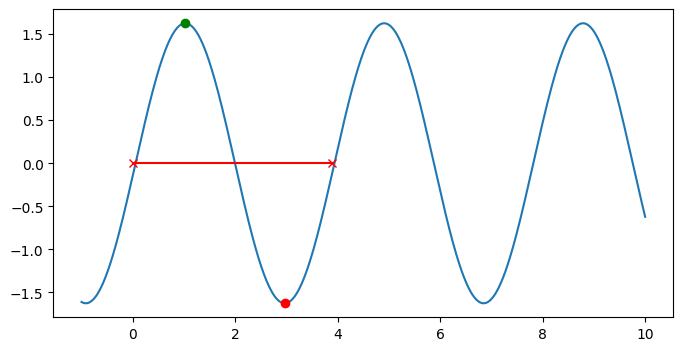

In [4]:
# update u only
t = torch.linspace(-1, 10, steps=1000)
func = get_exponential_map(u, v)

u_new, v_new = func(t)
z = value(u_new, v)
λᵤ, λᵥ = get_wavelength(u, v)
τᵤ, τᵥ = get_sol(u, v)
u1, _ = func(τᵤ)
u2, _ = func(τᵤ + λᵤ / 2)

# make figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, z)
_ = ax.plot([0, λᵤ], [0, 0], "-rx")
_ = ax.plot(τᵤ, value(u1, v), "-go")
_ = ax.plot(τᵤ + λᵤ / 2, value(u2, v), "-ro")

Wavelength ωᵤ: 3.8813
Wavelength ωᵥ: 8.0626
Phase      τᵤ: 1.0248
Phase      τᵥ: 2.2489


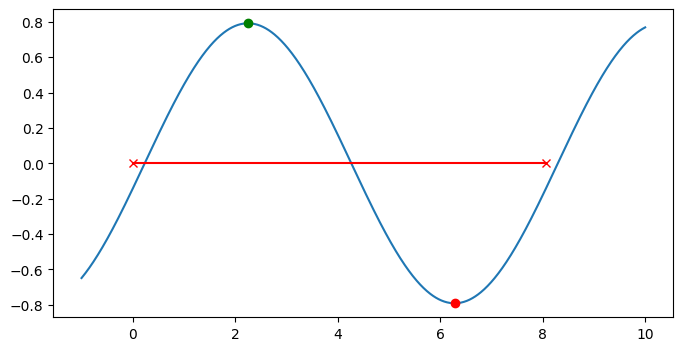

In [5]:
# update v only
t = torch.linspace(-1, 10, steps=1000)
func = get_exponential_map(u, v)
u_new, v_new = func(t)
z = value(u, v_new)
λᵤ, λᵥ = get_wavelength(u, v)
τᵤ, τᵥ = get_sol(u, v)
_, v1 = func(τᵥ)
_, v2 = func(τᵥ + λᵥ / 2)

# make figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, z)
_ = ax.plot([0, λᵥ], [0, 0], "-rx")
_ = ax.plot(τᵥ, value(u, v1), "-go")
_ = ax.plot(τᵥ + λᵥ / 2, value(u, v2), "-ro")

In [9]:
τᵤ, τᵥ, τᵤ + λᵤ / 2, τᵥ + λᵥ / 2

(tensor(1.0248), tensor(2.2489), tensor(2.9655), tensor(6.2802))

Wavelength ωᵤ: 3.8813
Wavelength ωᵥ: 8.0626


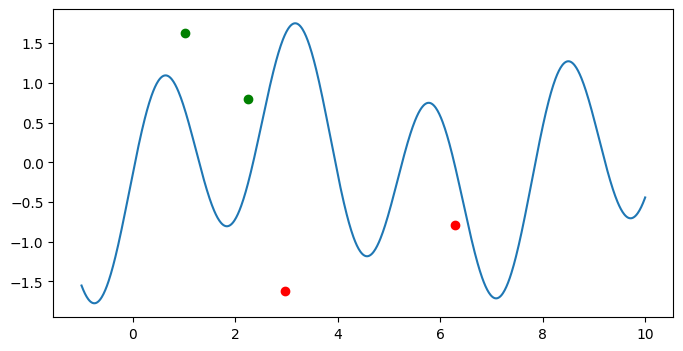

In [6]:
# update both
t = torch.linspace(-1, 10, steps=1000)
func = get_exponential_map(u, v)
z = value(*func(t))
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.plot(t, z)
_ = ax.plot(τᵤ, value(u1, v), "-go")
_ = ax.plot(τᵤ + λᵤ / 2, value(u2, v), "-ro")
_ = ax.plot(τᵥ, value(u, v1), "-go")
_ = ax.plot(τᵥ + λᵥ / 2, value(u, v2), "-ro")

## Idea combined descent

As the discussion of coordinate descent shows, we can find the solution sets:

$$ t₁^* = τ₁ + ω₁ℤ  \qquad t₂^* = τ₂ +ω₂ℤ $$

Generally, $ω₁$ and $ω₂$ will not be rational multiples of each other, so we cannot find a common multiple of $ω₁$ and $ω₂$.
However, we can find *approximate* least common multiples, i.e. we want to find integers $k₁$ and $k₂$ such that

$$ τ₁ + ω₁k₁ ≈ τ₂ + k₂ω₂ $$

or equivalently:

$$ k₁ω₁ + k₂ω₂ ≈ δ = τ₁ - τ₂$$

To make the problem well-posed, we need to constrain the magnitude of $k₁$ and $k₂$.

In [7]:
def best_rational_approx(x: float) -> tuple[int, int]:
    """Returns the best rational approximation of x with denominator <= 100."""
    x = float(x)
    best = (0, 1)
    for q in range(1, 100):
        p = round(q * x)
        if abs(x - p / q) < abs(x - best[0] / best[1]):
            best = (p, q)
    return best


best_rational_approx(6.0479)


def lcm_rational(x: float, y: float) -> tuple[int, int]:
    """Returns the least common multiple of the denominators of x and y."""
    x = float(x)
    y = float(y)
    _, q1 = best_rational_approx(x)
    _, q2 = best_rational_approx(y)
    return (q1 * q2) // math.gcd(q1, q2)


num = lcm_rational(λᵤ, λᵥ)
print(num * λᵤ, num * λᵥ)

tensor(3663.9202) tensor(7611.1387)


In [8]:
def best_rational_approx(x: float, d_max: int = 1000) -> tuple[int, int]:
    """Returns the best rational approximation of x with denominator <= d_max."""
    x = float(x)
    pstar, qstar = (0, 1)
    approx = pstar / qstar
    for q in range(1, d_max):
        p = round(q * x)
        if abs(x - p / q) < abs(x - approx):
            pstar, qstar = p, q
            approx = pstar / qstar

    approx = pstar / qstar
    relerr = abs(x - approx) / abs(x)
    print(
        f"approximation of {x:.4f} is {pstar}/{qstar}≈{approx:.4f}",
        f"relative error: {relerr:.3e}",
    )
    return pstar, qstar

In [9]:
# get time
γ = max(τu, τv) - min(τu, τv)
# consider normalized equation (ω₁/γ)k₁+(ω₂/γ)k₂=1
p1, q1 = best_rational_approx(λᵤ / γ, 80)
p2, q2 = best_rational_approx(λᵥ / γ, 80)
c = math.lcm(q1, q2)


def isolve(a, b, c):
    """Jim Carlson's solution to the linear diophantine equation ax+by=c"""
    q, r = divmod(a, b)

    if not r:
        return 0, c // b

    u, v = isolve(b, r, c)
    return v, u - q * v


k1, k2 = isolve(p1 * (c // q1), p2 * (c // q2), c)
λᵤ * k1 + τᵤ, λᵥ * k2 + τᵥ

approximation of 3.1709 is 130/41≈3.1707 relative error: 4.439e-05
approximation of 6.5869 is 303/46≈6.5870 relative error: 5.505e-06


(tensor(-18658876.), tensor(18657950.))

In [10]:
import sympy as sp
from sympy.solvers.diophantine.diophantine import diop_linear

# solve linear diofantine equation
k1, k2, t = sp.symbols("k1 k2 t", integer=True)
# sol = sp.solve(p1*k1/q1 + p2*k2/q2 -1, k1, k2)

sol = diop_linear((k1 * p1) * (c // q1) + (k2 * p2) * (c // q2) - c, param=t)
print(sol[0].subs(t, 1))

12423*t_0 - 4807414


In [11]:
(k1 * p1) * (c // q1) + (k2 * p2) * (c // q2) - c

5980*k1 + 12423*k2 - 1886

In [12]:
def solve_diophantine_approx(
    w1: float, w2: float, c: float, bound: int = 100
) -> tuple[int, int]:
    """Find integers k1, k2 such that k1*w1 + k2*w2 ≈ c."""
    w1 = float(w1)
    w2 = float(w2)
    c = float(c)
    best = (0, 1)
    for k1 in range(-bound, bound):
        for k2 in range(-bound, bound):
            if abs(k1 * w1 + k2 * w2 - c) < abs(best[0] * w1 + best[1] * w2 - c):
                best = (k1, k2)
    return best


solve_diophantine_approx(λᵤ, λᵥ, 6.0479)

(-94, 46)

## Idea: Coordinate Descent

The advantage of only updating u or only updating v is that, since we know the frequency, it allows us to constrain to a finite interval.
Moreover, we can prove that within this interval, since we are dealing with a sine-wave, there is precisely one global maximum and one global minimum.

We are lucky: there is an analytic solution to the global maximum of the function, which is given by the following formula. Assuming $gᵤ∈𝕋𝕊$ is the normalized tangent vector,
i.e. $⟨eᵤ∣u⟩=0$ and $‖eᵤ‖=1$, then the global maximum is given by

$\providecommand{\sign}{\operatorname{sign}}$
$$\begin{aligned}
    \max_t u(t)ᵀ A v 
       &= (\cos(λt) u + \sin(λt) eᵤ)^⊤ Av
    \\ &= (uᵀ A v)\cos(λt) + (eᵤᵀ A v)\sin(λt) 
    \\ &= a\cos(λt) + b\sin(λt)
\end{aligned}$$

Where $λ=‖gᵤ‖$, $a≔uᵀ A v$ and $b≔(eᵤᵀ A v)$. 

There are two critical points:

$$t_{1,2}^* = \{\tfrac{1}{λ}\arctan(\tfrac{b}{a})，\tfrac{1}{λ}\arctan(\tfrac{b}{a}) + \tfrac{π}{λ}\}$$

which gives the function values

$$ f(t_{1,2}^*) = \{\sign(a) \sqrt{a² + b²}, - \sign(a) \sqrt{a² + b²}\}$$

In particular, if $a>0$, then $t_1^*$ is the global maximum, and $t_2^*$ is the global minimum, else vice versa. The coefficients $\cos(λt)$ and $\sin(λt)$ are then given by

$$\begin{aligned}
    \cos(λt_1^*) &= +\sign(a)\frac{a}{\sqrt{a² + b²}} 
    &\qquad \sin(λt_1^*) &= +\sign(a)\frac{b}{\sqrt{a² + b²}} 
    \\ \cos(λt_2^*) &= -\sign(a)\frac{a}{\sqrt{a² + b²}}
    &\qquad \sin(λt_2^*) &= -\sign(a)\frac{b}{\sqrt{a² + b²}}
\end{aligned}$$


In particular, since $t^* ≔ t_1^*$ if $a>0$ and $t^*≔t_2^*$ if $a<0$ it follows that

$$\left.\begin{aligned}
    \cos(λt^*) &= \frac{a}{\sqrt{a² + b²}} 
    \\\sin(λt^*) &= \frac{b}{\sqrt{a² + b²}}
\end{aligned}\right\rbrace 
⟹ u(t^*) = \frac{a}{\sqrt{a² + b²}}u + \frac{b}{\sqrt{a² + b²}}\frac{g_u}{‖g_u‖}
$$

-----

Note that if we replace $\arctan(b/a)$ with the atan2 function, we can avoid the sign (essentially hiding it inside atan2), and we get the two solutions 

$$ f(t_{1,2}^*) = ±\sqrt{a² + b²}$$

Thus $t^*≔t_1^*$ is always the global maximum when using atan2.

The coefficients $\cos(λt^*)$ and $\sin(λt^*)$ are then given by

$$\begin{aligned}
    \cos(λt^*) &= \frac{a}{\sqrt{a² + b²}}
    &\qquad \sin(λt^*) &= \frac{b}{\sqrt{a² + b²}}
\end{aligned}$$

which agrees with the previous result.

### Resubstitute

Plugging the values $λ=‖gᵤ‖$, $a≔uᵀ A v=σᵤ$ and $b≔eᵤᵀAv=ρᵤ$, where $eᵤ = \frac{gᵤ}{‖gᵤ‖}$ and $gᵤ=Av-σᵤu$, back in gives, with some simplification:

$$\begin{aligned}
    u(t^*) &= &= \frac{σᵤ}{\sqrt{σᵤ² + ρᵤ²}}u + \frac{ρᵤ}{\sqrt{σᵤ² + ρᵤ²}}eᵤ
\end{aligned}$$

Since we are using floating point numbers and need to ensure normality, we can use the following formula:

$$\begin{aligned}
    u(t^*) &= σᵤu + ρᵤeᵤ
    & u(t^*) &= u(t^*)/‖u(t^*)‖
\end{aligned}$$

Note that 

$$\begin{aligned}
 ρᵤ = eᵤᵀ A v = \tfrac{1}{‖gᵤ‖} gᵤᵀAv = \tfrac{1}{‖gᵤ‖}(Av - σᵤ u)ᵀAv = \tfrac{‖Av‖² - σᵤ²}{‖gᵤ‖}
\end{aligned}$$

Thus

$$\begin{aligned}
 ρᵤeᵤ = \tfrac{‖Av‖² - σᵤ²}{‖gᵤ‖}\frac{gᵤ}{‖gᵤ‖} = \frac{‖Av‖² - σᵤ²}{‖gᵤ‖²}gᵤ
\end{aligned}$$

There is an issue here: since the gradient converges to zero, we are potentially dividing by zero. Fortunately, the formula simplifies:

$$
\frac{‖Av‖² - σᵤ²}{‖gᵤ‖²}
= \frac{‖Av‖² - σᵤ²}{‖Av - σᵤu‖²}
= \frac{‖Av‖² - σᵤ²}{‖Av‖² - 2⟨Av∣σᵤu⟩ + σᵤ²}
= \frac{‖Av‖² - σᵤ²}{‖Av‖² - σᵤ²}
= 1
$$

Therefore, the update formula is given by

$$
\boxed{u' = \frac{σᵤ}{\sqrt{1+σᵤ²}}u + \frac{1}{\sqrt{1+σᵤ²}}gᵤ}
$$

Moreover, we can first compute $u' = σᵤu + gᵤ$ and then normalize it.
Since $gᵤ=Av-σᵤu$, we have $u' = σᵤu + Av - σᵤu = Av$.

$$\boxed{u' = \operatorname{normalize}(Av)$$

Therefore, the power-iteration is precisely Riemannian coordinate descent!


which allows us to save a matrix-vector multiplication. However, this may be less numerically stable.

Moreover, the stopping criterion is given by

$$ ‖gᵤ‖ < α + βσᵤ ⟺ ρᵤ < α + βσᵤ $$

Note: both $σᵤ>0$ and $ρᵤ>0$ are guaranteed mathematically, but might need special attention numerically.

$$\begin{aligned}
    ρᵤ &= \frac{‖Av‖² - σᵤ²}{‖gᵤ‖} 
    \\ &= \frac{‖Av‖² - σᵤ²}{‖Av - σᵤ u‖}
    \\ &= \frac{‖dᵤ‖² - uᵀAv²}{‖Av - uᵀAv u‖}
\end{aligned}$$


<!-- 
$$\begin{aligned}
    \cos(λt^*) &= \frac{a}{\sqrt{a² + b²}} &&= \frac{λσᵤ}{\sqrt{(λσᵤ)² + (gᵤᵀ A v)²}}
    \\ \sin(λt^*) &= \frac{b}{\sqrt{a² + b²}} &&= \frac{gᵤᵀ A v}{\sqrt{(λσᵤ)² + (gᵤᵀ A v)²}}
\end{aligned}$$

Note that

$$\begin{aligned}
 gᵤᵀ A v = (Av - σᵤ u)ᵀ Av = ‖Av‖² - σᵤ² = ‖dᵤ‖² - σᵤ²
\end{aligned}$$

In particular: $\frac{gᵤᵀ A v}{‖gᵤ‖} = \frac{‖dᵤ‖²-σᵤ² }{‖dᵤ-σᵤ u‖}$


With some calculation:

$$ \sqrt{(λσᵤ)² + (gᵤᵀ A v)²} = ‖Av‖\sqrt{‖Av‖²+σᵤ²} $$ -->


## Pseudocode

```pseudo
for k in range(1, max_iter):
    { # update u
        # compute gradient
        dᵤ = A v
        # compute tangent vector
        σᵤ = ⟨u∣dᵤ⟩
        eᵤ = dᵤ - σᵤ⋅u
        λᵤ = ‖gᵤ‖
        eᵤ = gᵤ/λᵤ
        ρᵤ = ⟨eᵤ∣dᵤ⟩
        # compute coefficients
        γᵤ = sqrt(σᵤ² + ρᵤ²)
        # update u
        u = (σᵤ/γᵤ) u + (ρᵤ/γᵤ) gᵤ
        # ensure norm is 1 (optional?!)
        u = u / ‖u‖
        converged = λᵤ < α + βσᵤ
    }
    { # update v
        # compute gradient
        dᵥ = Aᵀ u
        # compute tangent vector
        σᵥ = vᵀ dᵥ
        gᵥ = dᵥ - σᵥ⋅v
        # compute coefficients
        a = uᵀ A v  # identical to σᵥ!
        b = uᵀ A gᵥ
        c = sqrt(a² + b²)
        # update v
        v = (a/c) v + (b/c) gᵥ
        # ensure norm is 1
        v = v / ‖v‖
        converged &= ‖gᵥ‖< α+βσᵥ
    }
    if converged:
        break
```


## Convergence

Note that as $gᵤ = Av - u (uᵀ Av) = Av - σu$ goes to zero, then b→0, and thus $t^*→0$.

Testing convergence should be done by checking the norm of the gradient:

$$ ‖∇f(x)‖ ≤ α + β‖f(x)‖ $$

This termination criteration comes from the Polyak-Łojasiewicz (PL) condition, which states that for a function $f$ to be PL, there must exist constants $μ>0$ such that

$$ \frac{1}{2}‖∇f(x)‖² ≥ μ(f(x)-f(x^*)) $$

Roughly, on a global scale the function must be bounded quadratic.

## Coordinate invariant stopping criterion

The stopping criterion should be scale invariant, i.e. if we changed units, say from meters to kilometers, then the stopping criterion should not change. In other words, it ought to be invariant under the transformation $f → λ⋅f$ for any $λ>0$. In particular, the naive gradient stopping criterion $‖∇f(x)‖<ε$ is not invariant! Instead, we can consider the following stopping criterion:

$$ ‖∇f(x)‖ < β |f(x)| $$

Which is invariant.  However, note that this is only reasonable to do if $f$ is non-negative, since otherwise we could just make $f$ arbitrarily negative, and then the stopping criterion would be trivially satisfied.

In this case it simplifies to

$$ ‖∇f(x)‖ < β f(x) $$

For some small constant $β>0$. However, also this variant has a deficit: if $∇f(x)$ decays not fast enough as $x→0$, then the stopping criterion will not be satisfied. For example, if $f(x)=x²$, it becomes $2|x| < β x²$, which, for small enough $x$, is never satisfiable.

Therefore, one can consider adding an absolute tolerance, i.e. the stopping criterion becomes

$$ ‖∇f(x)‖ < α + β f(x) $$

For some small positive constants $α$ and $β$.



In case of the singular triplet, the tangent-gradient vectors are given by

$$\begin{aligned}
    gᵤ &= Av - u (uᵀ Av) = Av - σu
    \\ gᵥ &= Aᵀ u - v (vᵀ Aᵀ u) = Aᵀ u - σv
\end{aligned}$$

So the stopping criterion becomes

$$ ‖(Av - σu, Aᵀ u - σv)‖ < α + β σ $$

which is however awkward to use. Instead, we can test two separate stopping criteria:

$$\begin{aligned}
       ‖Av - σu‖    &< α + β σ
    \\ ‖Aᵀ u - σv‖ &< α + β σ
\end{aligned}$$

Now, plugging in the iterates, we get

$$\begin{aligned}
       ‖gᵤ‖ &< α + β σᵤ
    \\ ‖gᵥ‖ &< α + β σᵥ
\end{aligned}$$

On a whole, this means that the algorithm only needs ~(2m+2n) memory.




## Simplifications

1. $a=σᵤ$ and $b=‖Av‖²-σᵤ²=‖dᵤ‖²-σᵤ²=ρᵤ²-σᵤ²$, hence $c=\sqrt{σᵤ² + (‖dᵤ‖²-σᵤ²)} = ‖dᵤ‖$

```pseudo
for k in range(1, max_iter):
    { # update u
        # compute gradient
        dᵤ = A v
        # compute tangent vector
        σᵤ = uᵀ dᵤ
        gᵤ = dᵤ - σᵤ ⋅ u 
        # compute coefficients
        a = uᵀ A v
        b = gᵤᵀ A v 
        c = ‖dᵤ‖
        # update u
        u = (a/c) u + (b/c) gᵤ
        # ensure norm is 1
        u = u / ‖u‖
    }
    { # update v
        # compute gradient
        dᵥ = Aᵀ u
        # compute tangent vector
        σᵥ = vᵀ dᵥ
        gᵥ = dᵥ - σᵥ⋅v
        # compute coefficients
        a = uᵀ A v  # identical to σᵥ!
        b = uᵀ A gᵥ
        c = sqrt(a² + b²)
        # update v
        v = (a/c) v + (b/c) gᵥ
        # ensure norm is 1
        v = v / ‖v‖
    }
    if ‖gᵤ‖< α+βσᵤ and ‖gᵥ‖< α+βσᵥ:
        break
```


## Idea Combined Descent


We follow the gradient along the two geodesics for both $u$ and $v$

$$\begin{aligned}
    \max_t u(t)ᵀ A v(t) 
       &= (\cos(λᵤt) u + \sin(λᵤt) eᵤ)^⊤ A (\cos(λᵥt) v + \sin(λᵥt) eᵥ)
    \\ &= (uᵀ A v)\cos(λᵤt)\cos(λᵥt) + (eᵤᵀ A v)\sin(λᵤt)\cos(λᵥt) + (uᵀ A eᵥ)\cos(λᵤt)\sin(λᵥt) + (eᵤᵀ A eᵥ)\sin(λᵤt)\sin(λᵥt)
\end{aligned}$$


We can try to simplify. Note that in the simultaneous computation, $σᵤ=uᵀdᵤ = uᵀAv = vᵀAᵀu = vᵀdᵥ = σᵥ$ are equal.
Therefore, using $gᵤ=Av-σᵤu$ and $gᵥ=Aᵀu-σᵥv$, $eᵤ=gᵤ/‖gᵤ‖$ and $eᵥ=gᵥ/‖gᵥ‖$, and $dᵤ=Av$ and $dᵥ=Aᵀu$, and $σᵤ=uᵀdᵤ$ and $σᵥ=vᵀdᵥ$:

$$\begin{aligned}
    (eᵤᵀ A v) &= \frac{gᵤᵀ A v}{‖gᵤ‖} =  \frac{(Av-σu)ᵀ A v}{‖Av-σu‖} =\frac{‖Av‖² - σ²}{‖Av-σu‖} = ‖Av-σu‖
\\ (uᵀ A eᵥ) &= \frac{uᵀ A gᵥ}{‖gᵥ‖} = \frac{uᵀ A (Aᵀ u - σ v)}{‖Aᵀ u - σ v‖} = \frac{‖Aᵀ u‖² - σ²}{‖Aᵀ u - σ v‖} = ‖Aᵀ u - σ v‖
\\ (eᵤᵀ A eᵥ) &= \frac{gᵤᵀ A gᵥ}{‖gᵤ‖⋅‖gᵥ‖} = \frac{(Av-σu)ᵀ A (Aᵀ u - σ v)}{‖Av-σu‖⋅‖Aᵀ u - σ v‖} = \frac{vᵀAᵀAAᵀu - σ‖Av‖² - σ‖Aᵀu‖² + σ³}{‖Av-σu‖⋅‖Aᵀ u - σ v‖}
\end{aligned}$$


Note: $‖Av-σu‖² = ‖Av‖² - 2σuᵀAv + σ²‖u‖² = ‖Av‖² - 2σ² + σ² = ‖Av‖² - σ²$

### Note: Product of sine waves


$$\begin{aligned}
    \sin(ω₁t)\sin(ω₂t) &= \tfrac{1}{2}(\cos((ω₁-ω₂)t) - \cos((ω₁+ω₂)t))
\\  \cos(ω₁t)\cos(ω₂t) &= \tfrac{1}{2}(\cos((ω₁-ω₂)t) + \cos((ω₁+ω₂)t))
\\  \sin(ω₁t)\cos(ω₂t) &= \tfrac{1}{2}(\sin((ω₁-ω₂)t) + \sin((ω₁+ω₂)t))
\\  \cos(ω₁t)\sin(ω₂t) &= \tfrac{1}{2}(\sin((ω₁+ω₂)t) - \sin((ω₁-ω₂)t))
\end{aligned}$$

Consequently, optimizing $u(t)ᵀAv(t)$ is equivalent to optimizing a sum of sine waves.

We can take several approaches:

1. alternating optimization: optimize $u$ and $v$ separately in a block coordinate descent fashion
2. joint optimization: optimize $u$ and $v$ simultaneously




